<a href="https://colab.research.google.com/github/gegretel/AML5/blob/master/Project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 5 - Team 2
*   Joe
*   Abby
*   Getong

In this project, we work on the data set that has been prepared to analyze factors relating to readmission as well as other outcomes pertaining to patients with diabetes.

Data Set Information:

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

1.   It is an inpatient encounter (a hospital admission).
2.   It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
3.   The length of stay was at least 1 day and at most 14 days.
4.   Laboratory tests were performed during the encounter.
5.   Medications were administered during the encounter.
6.   The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

The following instructions have been performed:
1.  Perform data scrubbing to deal with missing data, and then scale the data. 
2.  Find out which features have most influence on patients with diabetes or being readmitted, e.g., age, race, weight, blood pressure, etc.
3.  Use RF and SVM (linear as well as nonlinear kernels , as necessary) to learn classification of diabetic patients and those being readmitted.
4.  If using a LinearSVC, also use SVC and SGDClassifier to see if you can get them to roughly produce the same model.
5.  Calculate and present performance parameters (e.g. accuracy, etc.) of each model using appropriate graphs such as bar charts.

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%ls /content

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
ls: cannot access '/content/gdrive': Transport endpoint is not connected
drive/  gdrive/  sample_data/


In [0]:
#%cd /content/drive/My Drive/Colab Notebooks

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
import pandas as pd
os.chdir("/content/gdrive/My Drive/")

In [0]:
diabetic=pd.read_csv("./Colab Notebooks/diabetic_data.csv")
diabetic.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [0]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

# Data Scrubbing

Weight attribute was considered to be too
sparse and it was not included in further analysis. 

Payer code was removed since it had a high percentage of missing values and it was not considered relevant to the outcome.

Medical specialty attribute has over 50% missing data.

Therefore, these three attributes are dropped.

Reference: http://downloads.hindawi.com/journals/bmri/2014/781670.pdf

In [0]:
diabetic = diabetic.drop("weight", axis=1)
diabetic = diabetic.drop("payer_code", axis=1)
diabetic = diabetic.drop("medical_specialty", axis=1)


In [0]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 47 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
diag_1                      101766 non-null object
diag_2                      101766 non-null object
diag_3                      101766

Since we are primarily interested in factors that lead to early readmission, we defined the readmission attribute (outcome) as having two values: “readmitted,” if the patient was readmitted within 30 days of discharge or “otherwise,” which covers both readmission after 30 days and no readmission at all.

Reference: http://downloads.hindawi.com/journals/bmri/2014/781670.pdf

In [0]:
diabetic = diabetic.replace({"readmitted": ">30"}, "No")
diabetic = diabetic.replace({"readmitted": "<30"}, "Yes")


In [0]:
diabetic["readmitted"][:15]

0      NO
1      No
2      NO
3      NO
4      NO
5      No
6      NO
7      No
8      NO
9      NO
10     No
11    Yes
12    Yes
13     NO
14     No
Name: readmitted, dtype: object

We thus used only one encounter per patient; in particular, we considered only the first encounter for each patient as the primary admission and determined whether or not they were readmitted within 30 days.

In [0]:
diabetic = diabetic.drop_duplicates(subset=["patient_nbr"])

In [0]:
diabetic["encounter_id"].count()

71518

Now we have 71518 distinctive patients records without same patients that have multiple visit records.

Then we drop rows that indicates the patient was deceased which means that they will not be readmitted.

In [0]:
diabetic = diabetic[diabetic.discharge_disposition_id != 11 ]

In [0]:
diabetic["encounter_id"].count()

70441

In [0]:
diabetic["race"][:20]

0           Caucasian
1           Caucasian
2     AfricanAmerican
3           Caucasian
4           Caucasian
5           Caucasian
6           Caucasian
7           Caucasian
8           Caucasian
9           Caucasian
10    AfricanAmerican
11    AfricanAmerican
12          Caucasian
13          Caucasian
14    AfricanAmerican
15    AfricanAmerican
16    AfricanAmerican
17          Caucasian
18    AfricanAmerican
19                  ?
Name: race, dtype: object

Columns "Race" have 2% missing data, it's not a lot, therefore they are filled with "Other".

In [0]:
diabetic["race"].replace("?","Other",inplace = True)

In [0]:
diabetic["race"][:20]

0           Caucasian
1           Caucasian
2     AfricanAmerican
3           Caucasian
4           Caucasian
5           Caucasian
6           Caucasian
7           Caucasian
8           Caucasian
9           Caucasian
10    AfricanAmerican
11    AfricanAmerican
12          Caucasian
13          Caucasian
14    AfricanAmerican
15    AfricanAmerican
16    AfricanAmerican
17          Caucasian
18    AfricanAmerican
19              Other
Name: race, dtype: object

Then we'll need to make a desicion on other columns which has small amount of missing data, including "diag_1" <0.1%, "diag_2" 0.3%, "diag_3" 1.3%.

Since this project is only targeting the diabetes here which has value as 250.xx. All values other than this tag will be taged as 'No' while all diagnose as diabetes will be taged as 'Yes'. 

In [0]:
diabetic["diag_1"][0:10]

0    250.83
1       276
2       648
3         8
4       197
5       414
6       414
7       428
8       398
9       434
Name: diag_1, dtype: object

In [0]:
diabetic["diag_1"].replace("^(?!250).*","No",inplace = True,regex=True)
diabetic["diag_1"].replace("^250.*","Yes",inplace = True,regex=True)

In [0]:
diabetic["diag_1"][0:10]

0    Yes
1     No
2     No
3     No
4     No
5     No
6     No
7     No
8     No
9     No
Name: diag_1, dtype: object

Let's do the same on 'diag_2' and 'diag_3'.

In [0]:
diabetic["diag_2"].replace("^(?!250).*","No",inplace = True,regex=True)
diabetic["diag_2"].replace("^250.*","Yes",inplace = True,regex=True)
diabetic["diag_3"].replace("^(?!250).*","No",inplace = True,regex=True)
diabetic["diag_3"].replace("^250.*","Yes",inplace = True,regex=True)

In [0]:
diabetic["diag_2"][0:10]

0     No
1    Yes
2    Yes
3    Yes
4     No
5     No
6     No
7     No
8     No
9     No
Name: diag_2, dtype: object

Now, all missing data have been handled. Since there are three diagnoses in the columns, here we unite these three columns into 1 when diagnose of diabetes exist in one of the three.

In [0]:
diabetic["Cons_diag"] = 0

Value "1" means the patient was once diagnosed for diabetes, whereas "0" means no diabete diagnosed.

In [0]:
diabetic["Cons_diag"][diabetic.diag_1=="Yes"] = 1
diabetic["Cons_diag"][diabetic.diag_2=="Yes"] = 1
diabetic["Cons_diag"][diabetic.diag_3=="Yes"] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doi

In [0]:
diabetic["Cons_diag"][:20]

0     1
1     1
2     1
3     1
4     1
5     1
6     0
7     1
8     0
9     0
10    1
11    0
12    1
13    0
14    0
15    0
16    0
17    1
18    0
19    0
Name: Cons_diag, dtype: int64

In [0]:
diabetic["Cons_diag"].value_counts()

0    42806
1    27635
Name: Cons_diag, dtype: int64

Now we can drop the colums: "diag_1", "diag_2" and "diag_3"

In [0]:
diabetic = diabetic.drop("diag_1",axis=1)
diabetic = diabetic.drop("diag_2",axis=1)
diabetic = diabetic.drop("diag_3",axis=1)

In [0]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70441 entries, 0 to 101765
Data columns (total 45 columns):
encounter_id                70441 non-null int64
patient_nbr                 70441 non-null int64
race                        70441 non-null object
gender                      70441 non-null object
age                         70441 non-null object
admission_type_id           70441 non-null int64
discharge_disposition_id    70441 non-null int64
admission_source_id         70441 non-null int64
time_in_hospital            70441 non-null int64
num_lab_procedures          70441 non-null int64
num_procedures              70441 non-null int64
num_medications             70441 non-null int64
number_outpatient           70441 non-null int64
number_emergency            70441 non-null int64
number_inpatient            70441 non-null int64
number_diagnoses            70441 non-null int64
max_glu_serum               70441 non-null object
A1Cresult                   70441 non-null object
met

Similarly, we replace column "readmitted" with a new int64 column. 

Value "1" means readmitted, "0" means not readmitted.

In [0]:
diabetic["re_ad"] = 0

In [0]:
diabetic["re_ad"][diabetic.readmitted=="Yes"] = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
diabetic["re_ad"][:15]

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    1
12    1
13    0
14    0
Name: re_ad, dtype: int64

In [0]:
diabetic["readmitted"][:15]

0      NO
1      No
2      NO
3      NO
4      NO
5      No
6      NO
7      No
8      NO
9      NO
10     No
11    Yes
12    Yes
13     NO
14     No
Name: readmitted, dtype: object

Then, drop the column "readmitted".

In [0]:
diabetic = diabetic.drop("readmitted",axis=1)

In [0]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70441 entries, 0 to 101765
Data columns (total 45 columns):
encounter_id                70441 non-null int64
patient_nbr                 70441 non-null int64
race                        70441 non-null object
gender                      70441 non-null object
age                         70441 non-null object
admission_type_id           70441 non-null int64
discharge_disposition_id    70441 non-null int64
admission_source_id         70441 non-null int64
time_in_hospital            70441 non-null int64
num_lab_procedures          70441 non-null int64
num_procedures              70441 non-null int64
num_medications             70441 non-null int64
number_outpatient           70441 non-null int64
number_emergency            70441 non-null int64
number_inpatient            70441 non-null int64
number_diagnoses            70441 non-null int64
max_glu_serum               70441 non-null object
A1Cresult                   70441 non-null object
met

Consider HbA1c might be highly related to the diagnoses for diabetes, here A1Cresult is transformed into numeric values.

1.   "None"   => 0
2.   "Norm"   => 1
3.   ">7"     => 2
4.   ">8"     => 3



In [0]:
diabetic["HbA1c"] = 0
diabetic["HbA1c"][diabetic.A1Cresult=="Norm"] = 1
diabetic["HbA1c"][diabetic.A1Cresult==">7"] = 2
diabetic["HbA1c"][diabetic.A1Cresult==">8"] = 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys

In [0]:
diabetic["A1Cresult"][70:100]

73     None
74       >7
75     None
76     None
77     None
80     None
82     None
83     None
84     None
85     None
86     None
87     None
88     None
89     None
90     None
91     None
92     None
93     None
94     None
95     None
96     None
97     None
98       >8
99     None
102    None
103    Norm
104    None
105    None
106    None
107    Norm
Name: A1Cresult, dtype: object

In [0]:
diabetic["HbA1c"][70:100]

73     0
74     2
75     0
76     0
77     0
80     0
82     0
83     0
84     0
85     0
86     0
87     0
88     0
89     0
90     0
91     0
92     0
93     0
94     0
95     0
96     0
97     0
98     3
99     0
102    0
103    1
104    0
105    0
106    0
107    1
Name: HbA1c, dtype: int64

Good, data validated, now we drop the column "A1Cresult".

In [0]:
diabetic = diabetic.drop("A1Cresult",axis=1)

# Data Preparation

In [0]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [0]:
train_set, test_set = split_train_test(diabetic, 0.2)
len(train_set)

56353

In [0]:
len(test_set)

14088

Here we did not use 'train_test_split' from sklearn because, two columns were unreasonably missing after this build-in function called.

In [0]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56353 entries, 36563 to 21161
Data columns (total 45 columns):
encounter_id                56353 non-null int64
patient_nbr                 56353 non-null int64
race                        56353 non-null object
gender                      56353 non-null object
age                         56353 non-null object
admission_type_id           56353 non-null int64
discharge_disposition_id    56353 non-null int64
admission_source_id         56353 non-null int64
time_in_hospital            56353 non-null int64
num_lab_procedures          56353 non-null int64
num_procedures              56353 non-null int64
num_medications             56353 non-null int64
number_outpatient           56353 non-null int64
number_emergency            56353 non-null int64
number_inpatient            56353 non-null int64
number_diagnoses            56353 non-null int64
max_glu_serum               56353 non-null object
metformin                   56353 non-null object


Still have 45 columns, good.

Take a further look into the database, there are 16 columns that are numeric. Let's take them out.

In [0]:
diabetic_num = train_set.drop(['race','gender','age', 
                              'max_glu_serum', 'metformin', 'repaglinide', 'nateglinide',
                              'chlorpropamide','glimepiride','acetohexamide','glipizide',
                              'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose',
                              'miglitol','troglitazone','tolazamide','examide','citoglipton',
                              'insulin','glyburide-metformin','glipizide-metformin',
                              'glimepiride-pioglitazone','metformin-rosiglitazone',
                              'metformin-pioglitazone','change','diabetesMed'],axis=1)

In [0]:
diabetic_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56353 entries, 36563 to 21161
Data columns (total 16 columns):
encounter_id                56353 non-null int64
patient_nbr                 56353 non-null int64
admission_type_id           56353 non-null int64
discharge_disposition_id    56353 non-null int64
admission_source_id         56353 non-null int64
time_in_hospital            56353 non-null int64
num_lab_procedures          56353 non-null int64
num_procedures              56353 non-null int64
num_medications             56353 non-null int64
number_outpatient           56353 non-null int64
number_emergency            56353 non-null int64
number_inpatient            56353 non-null int64
number_diagnoses            56353 non-null int64
Cons_diag                   56353 non-null int64
re_ad                       56353 non-null int64
HbA1c                       56353 non-null int64
dtypes: int64(16)
memory usage: 7.3 MB


In [0]:
corr_matrix = diabetic_num.corr()
corr_matrix["Cons_diag"].sort_values(ascending=False)

Cons_diag                   1.000000
HbA1c                       0.122487
admission_type_id           0.027587
number_emergency            0.007634
re_ad                      -0.008505
admission_source_id        -0.021116
number_inpatient           -0.023964
discharge_disposition_id   -0.025603
number_outpatient          -0.027760
num_lab_procedures         -0.068278
num_procedures             -0.093211
patient_nbr                -0.094782
encounter_id               -0.105173
time_in_hospital           -0.138743
num_medications            -0.143921
number_diagnoses           -0.417879
Name: Cons_diag, dtype: float64

From the numeric colums, the most corelated column to diagnosis of diabetes is 'number_diagnoses'.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

NameError: ignored

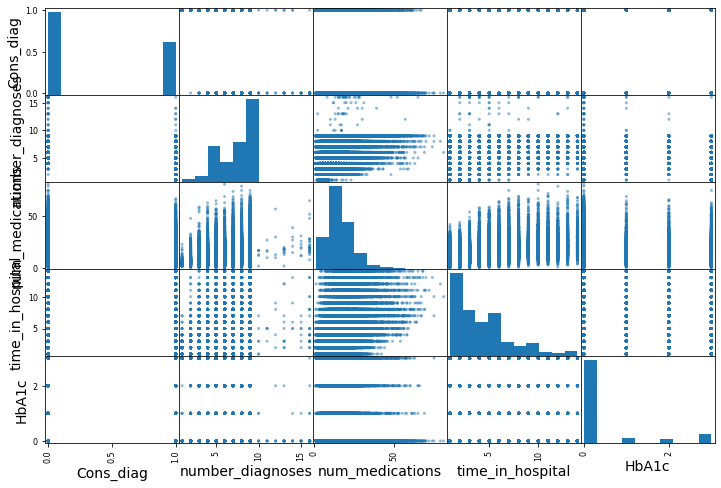

In [0]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["Cons_diag", "number_diagnoses", "num_medications","time_in_hospital","HbA1c"]
scatter_matrix(diabetic_num[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [0]:
corr_matrix = diabetic_num.corr()
corr_matrix["re_ad"].sort_values(ascending=False)

re_ad                       1.000000
number_inpatient            0.102937
discharge_disposition_id    0.064957
time_in_hospital            0.054446
number_diagnoses            0.042758
num_medications             0.036680
num_lab_procedures          0.029971
number_emergency            0.027454
number_outpatient           0.007629
admission_source_id         0.005368
patient_nbr                 0.004257
num_procedures              0.002310
admission_type_id           0.000013
Cons_diag                  -0.008505
HbA1c                      -0.009776
encounter_id               -0.047151
Name: re_ad, dtype: float64

From the numeric colums, it seems all these columns have very low corelations with 'readmitted'.

In [0]:
diabetic_train = train_set.drop("Cons_diag", axis=1) # drop labels for training set
diabetic_train = diabetic_train.drop("re_ad", axis=1)
dia_labels_diag = train_set["Cons_diag"].copy()
dia_labels_read = train_set["re_ad"].copy()

Now let's build a pipeline for preprocessing the numerical attributes with scaling:

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([('std_scaler', StandardScaler())])

diabetic_tr = num_pipeline.fit_transform(diabetic_num)

In [0]:
diabetic_tr

array([[-0.44167186,  0.74301342, -0.73174058, ...,  1.24629849,
         3.20091536,  2.81240975],
       [-0.94669309, -0.9783004 , -0.06767563, ...,  1.24629849,
        -0.31241064,  2.81240975],
       [-0.47466256,  1.25738643, -0.73174058, ..., -0.802376  ,
        -0.31241064, -0.43380394],
       ...,
       [ 0.73947577, -1.34344443, -0.06767563, ..., -0.802376  ,
        -0.31241064, -0.43380394],
       [-1.49134838, -1.13924841,  2.58858414, ..., -0.802376  ,
        -0.31241064, -0.43380394],
       [-0.8256232 , -0.87191168,  0.59638931, ..., -0.802376  ,
        -0.31241064, -0.43380394]])

Next we'll deal with categorical columns.

In [0]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

In [0]:
from sklearn.compose import ColumnTransformer

num_attribs = list(diabetic_num)
cat_attribs = ['race','gender','age',
                              'max_glu_serum','metformin','repaglinide','nateglinide',
                              'chlorpropamide','glimepiride','acetohexamide','glipizide',
                              'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose',
                              'miglitol','troglitazone','tolazamide','examide','citoglipton',
                              'insulin','glyburide-metformin','glipizide-metformin',
                              'glimepiride-pioglitazone','metformin-rosiglitazone',
                              'metformin-pioglitazone','change','diabetesMed']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

dia_prepared = full_pipeline.fit_transform(train_set)

In [0]:
dia_prepared.shape

(56353, 110)

Since all the data has transformed into 2D float array, we are unable to run correlation matrix to seek the most correlated attributes among non-numeric columns.

Now let's do the same on the test data set.

In [0]:
test_num = test_set.drop(['race','gender','age', 
                              'max_glu_serum', 'metformin', 'repaglinide', 'nateglinide',
                              'chlorpropamide','glimepiride','acetohexamide','glipizide',
                              'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose',
                              'miglitol','troglitazone','tolazamide','examide','citoglipton',
                              'insulin','glyburide-metformin','glipizide-metformin',
                              'glimepiride-pioglitazone','metformin-rosiglitazone',
                              'metformin-pioglitazone','change','diabetesMed'],axis=1)

In [0]:
test_labels_diag = test_set["Cons_diag"].copy()
test_labels_read = test_set["re_ad"].copy()
diabetic_test = test_set.drop("Cons_diag", axis=1) # drop labels for testing set
diabetic_test = diabetic_test.drop("re_ad", axis=1)

In [0]:
test_tr = num_pipeline.fit_transform(test_num)

In [0]:
num_attribs = list(test_num)
cat_attribs = ['race','gender','age',
                              'max_glu_serum','metformin','repaglinide','nateglinide',
                              'chlorpropamide','glimepiride','acetohexamide','glipizide',
                              'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose',
                              'miglitol','troglitazone','tolazamide','examide','citoglipton',
                              'insulin','glyburide-metformin','glipizide-metformin',
                              'glimepiride-pioglitazone','metformin-rosiglitazone',
                              'metformin-pioglitazone','change','diabetesMed']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

In [0]:
test_prepared = full_pipeline.fit_transform(test_set)

In [0]:
test_prepared.shape

(14088, 100)

It is probably the variance of data value of the training set and the testing set causing the difference of column number after transforming all the non-numeric data into numeric data.


We'll manually transform columns "race", "age", "max_glu_serum", "gender","change", "diabetesMed" into numeric data.

Race is transformed into numeric values.

1.   "Other"               => 0
2.   "Caucasian"           => 1
3.   "AfricanAmerican"     => 2
4.   "Asian"               => 3
5.   "Hispanic"            => 4


In [0]:
diabetic["Race"] = 0
diabetic["Race"][diabetic.race=="Caucasian"] = 1
diabetic["Race"][diabetic.race=="AfricanAmerican"] = 2
diabetic["Race"][diabetic.race=="Asian"] = 3
diabetic["Race"][diabetic.race=="Hispanic"] = 4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys

In [0]:
diabetic = diabetic.drop("race",axis=1)

Gender is transformed into numeric values.

1.   "Unknown/Invalid"  => 0
2.   "Female"           => 1
3.   "Male"             => 2

In [0]:
diabetic["Gender"] = 0
diabetic["Gender"][diabetic.gender=="Female"] = 1
diabetic["Gender"][diabetic.gender=="Male"] = 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
diabetic = diabetic.drop("gender",axis=1)

Age is transformed into numeric values.

1.   "[0-10)"               => 0
2.   "[10-20)"              => 1
3.   "[20-30)"              => 2
4.   "[30-40)"              => 3
5.   "[40-50)"              => 4
5.   "[50-60)"              => 5
6.   "[60-70)"              => 6
7.   "[70-80)"              => 7
8.   "[80-90)"              => 8
9.   "[90-100)"             => 9

In [0]:
diabetic["Age"] = 0
diabetic["Age"][diabetic.age=="[10-20)"] = 1
diabetic["Age"][diabetic.age=="[20-30)"] = 2
diabetic["Age"][diabetic.age=="[30-40)"] = 3
diabetic["Age"][diabetic.age=="[40-50)"] = 4
diabetic["Age"][diabetic.age=="[50-60)"] = 5
diabetic["Age"][diabetic.age=="[60-70)"] = 6
diabetic["Age"][diabetic.age=="[70-80)"] = 7
diabetic["Age"][diabetic.age=="[80-90)"] = 8
diabetic["Age"][diabetic.age=="[90-100)"] = 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys

In [0]:
diabetic = diabetic.drop("age",axis=1)

Change is transformed into numeric values.

1.   "Ch"               => 0
2.   "No"               => 1

In [0]:
diabetic["Change"] = 0
diabetic["Change"][diabetic.change=="No"] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
diabetic = diabetic.drop("change",axis=1)

DiabetesMed is transformed into numeric values.

1.   "Yes"               => 0
2.   "No"                => 1

In [0]:
diabetic["DiabetesMed"] = 0
diabetic["DiabetesMed"][diabetic.diabetesMed=="No"] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
diabetic = diabetic.drop("diabetesMed",axis=1)

Max_glu_serum is transformed into numeric values.

1. "None" => 0
2. "Norm" => 1
3. ">200" => 2
4. ">300" => 3


In [0]:
diabetic["Max_glu_serum"] = 0
diabetic["Max_glu_serum"][diabetic.max_glu_serum=="Norm"] = 1
diabetic["Max_glu_serum"][diabetic.max_glu_serum==">200"] = 2
diabetic["Max_glu_serum"][diabetic.max_glu_serum==">300"] = 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys

In [0]:
diabetic = diabetic.drop("max_glu_serum",axis=1)

In [0]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70441 entries, 0 to 101765
Data columns (total 45 columns):
encounter_id                70441 non-null int64
patient_nbr                 70441 non-null int64
admission_type_id           70441 non-null int64
discharge_disposition_id    70441 non-null int64
admission_source_id         70441 non-null int64
time_in_hospital            70441 non-null int64
num_lab_procedures          70441 non-null int64
num_procedures              70441 non-null int64
num_medications             70441 non-null int64
number_outpatient           70441 non-null int64
number_emergency            70441 non-null int64
number_inpatient            70441 non-null int64
number_diagnoses            70441 non-null int64
metformin                   70441 non-null object
repaglinide                 70441 non-null object
nateglinide                 70441 non-null object
chlorpropamide              70441 non-null object
glimepiride                 70441 non-null object
ace

The dataset contains 23 features for 23 drugs (or combos) which indicate for each of these, whether a change in that medication was made or not during the current hospital stay of patient. Medication change for diabetics upon admission has been shown by previous research to be associated with lower readmission rates.

Therefore, we decide to drop these non-numeric columns.

reference: https://medium.com/berkeleyischool/how-to-use-machine-learning-to-predict-hospital-readmissions-part-1-bd137cbdba07

In [0]:
diabetic_num = diabetic.drop(['metformin', 'repaglinide', 'nateglinide',
                              'chlorpropamide','glimepiride','acetohexamide','glipizide',
                              'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose',
                              'miglitol','troglitazone','tolazamide','examide','citoglipton',
                              'insulin','glyburide-metformin','glipizide-metformin',
                              'glimepiride-pioglitazone','metformin-rosiglitazone',
                              'metformin-pioglitazone'],axis=1)

In [0]:
diabetic_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70441 entries, 0 to 101765
Data columns (total 22 columns):
encounter_id                70441 non-null int64
patient_nbr                 70441 non-null int64
admission_type_id           70441 non-null int64
discharge_disposition_id    70441 non-null int64
admission_source_id         70441 non-null int64
time_in_hospital            70441 non-null int64
num_lab_procedures          70441 non-null int64
num_procedures              70441 non-null int64
num_medications             70441 non-null int64
number_outpatient           70441 non-null int64
number_emergency            70441 non-null int64
number_inpatient            70441 non-null int64
number_diagnoses            70441 non-null int64
Cons_diag                   70441 non-null int64
re_ad                       70441 non-null int64
HbA1c                       70441 non-null int64
Race                        70441 non-null int64
Gender                      70441 non-null int64
Age     

Let's run the corr-matrix again.

In [0]:
corr_matrix = diabetic_num.corr()
corr_matrix["Cons_diag"].sort_values(ascending=False)

Cons_diag                   1.000000
HbA1c                       0.123378
Race                        0.056638
Max_glu_serum               0.035608
admission_type_id           0.029707
number_emergency            0.008659
Gender                      0.001255
re_ad                      -0.010278
admission_source_id        -0.022414
discharge_disposition_id   -0.024340
number_inpatient           -0.027235
number_outpatient          -0.027827
DiabetesMed                -0.066659
num_lab_procedures         -0.066782
Change                     -0.068617
num_procedures             -0.094242
patient_nbr                -0.094585
encounter_id               -0.106001
time_in_hospital           -0.136866
num_medications            -0.142426
Age                        -0.250490
number_diagnoses           -0.418840
Name: Cons_diag, dtype: float64

After taking "race", "age", "gender","change", "max_glu_serum" and "diabetesMed" into consideration, the column with the highest correlation to "Cons_diag" is "number_diagnoses", followed by "Age".

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

NameError: ignored

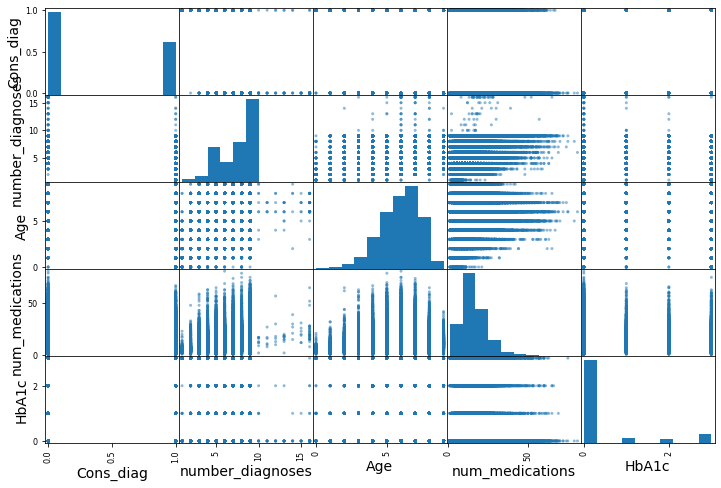

In [0]:
attributes = ["Cons_diag", "number_diagnoses", "Age", "num_medications", "HbA1c"]
scatter_matrix(diabetic_num[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [0]:
corr_matrix["re_ad"].sort_values(ascending=False)

re_ad                       1.000000
number_inpatient            0.100671
discharge_disposition_id    0.065299
time_in_hospital            0.054757
Age                         0.045701
number_diagnoses            0.044247
num_medications             0.036067
num_lab_procedures          0.031682
number_emergency            0.028190
Max_glu_serum               0.009238
number_outpatient           0.008764
admission_source_id         0.005402
patient_nbr                 0.005099
num_procedures              0.000068
admission_type_id          -0.001643
Gender                     -0.002167
Race                       -0.002371
HbA1c                      -0.009570
Cons_diag                  -0.010278
Change                     -0.015013
DiabetesMed                -0.028076
encounter_id               -0.047624
Name: re_ad, dtype: float64

The columns with the highese correlation to "re_ad" is "number_inpatient", but the correlation is pretty low.

# Random Forrest Classifier Model

In [0]:
train_set, test_set = split_train_test(diabetic_num, 0.2)
len(train_set)

56353

In [0]:
train_set.shape

(56353, 22)

In [0]:
diabetic_train = train_set.drop("Cons_diag", axis=1) # drop labels for training set
diabetic_train = diabetic_train.drop("re_ad", axis=1)
dia_labels_diag = train_set["Cons_diag"].copy()
dia_labels_read = train_set["re_ad"].copy()

In [0]:
test_labels_diag = test_set["Cons_diag"].copy()
test_labels_read = test_set["re_ad"].copy()
diabetic_test = test_set.drop("Cons_diag", axis=1) # drop labels for testing set
diabetic_test = diabetic_test.drop("re_ad", axis=1)

In [0]:
diabetic_train.shape

(56353, 20)

In [0]:
diabetic_test.shape

(14088, 20)

Scaling the data.

In [0]:
dia_tr = num_pipeline.fit_transform(train_set)

In [0]:
dia_te = num_pipeline.fit_transform(test_set)

Train a Random Forest classifier on the dataset 

In [0]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [0]:
import time
t0 = time.time()
rnd_clf.fit(dia_tr, dia_labels_diag)
t1 = time.time()
print("Training took {:.2f}s".format(t1 - t0))

Training took 3.15s


Accuracy score for predicting diagnoses of diabetes.

In [0]:
from sklearn.metrics import accuracy_score
dia_pred = rnd_clf.predict(dia_te)
as_rf_diag = accuracy_score(test_labels_diag, dia_pred)
as_rf_diag

1.0

Confusion Matrix, Precision and Recall for Prediction of Diagnoses for diabetes.

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels_diag, dia_pred)

array([[8597,    0],
       [   0, 5491]])

In [0]:
from sklearn.metrics import precision_score, recall_score
ps_rf_diag = precision_score(test_labels_diag, dia_pred)
ps_rf_diag

1.0

In [0]:
rs_rf_diag = recall_score(test_labels_diag, dia_pred)
rs_rf_diag

1.0

Accuracy score for predicting re-admitted.

In [0]:
rnd_clf.fit(dia_tr, dia_labels_read)
read_pred = rnd_clf.predict(dia_te)
as_rf_read = accuracy_score(test_labels_read, read_pred)
as_rf_read

1.0

Confusion Matrix, Precision and Recall for Prediction of re-admitted.

In [0]:
confusion_matrix(test_labels_read, read_pred)

array([[12854,     0],
       [    0,  1234]])

In [0]:
ps_rf_read = precision_score(test_labels_read, read_pred)
ps_rf_read

1.0

In [0]:
rs_rf_read = recall_score(test_labels_read, read_pred)
rs_rf_read

1.0

Let's try using k-cross validation.

In [0]:
from sklearn.model_selection import cross_val_score
RFCscore_d = cross_val_score(rnd_clf, dia_tr, dia_labels_diag, cv=5, scoring="accuracy")
RFCscore_d

array([1., 1., 1., 1., 1.])

In [0]:
RFCscore_r = cross_val_score(rnd_clf, dia_tr, dia_labels_read, cv=5, scoring="accuracy")
RFCscore_r

array([1., 1., 1., 1., 1.])

# SVM Model

# Linear Kernel

In [0]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
svm_clf = Pipeline([("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),])
svm_clf.fit(dia_tr, dia_labels_diag)


Pipeline(memory=None,
         steps=[('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [0]:
svm_dia_pred = svm_clf.predict(dia_te)

In [0]:
as_svm_diag = accuracy_score(test_labels_diag, svm_dia_pred)
as_svm_diag

1.0

In [0]:
SVMCscore_d = cross_val_score(svm_clf, dia_tr, dia_labels_diag, cv=5, scoring="accuracy")
SVMCscore_d

array([1., 1., 1., 1., 1.])

Confusion Matrix, Precision and Recall for Prediction of Diagnoses for diabetes.

In [0]:
confusion_matrix(test_labels_diag, svm_dia_pred)

array([[8597,    0],
       [   0, 5491]])

In [0]:
ps_svm_diag = precision_score(test_labels_diag, svm_dia_pred)
ps_svm_diag

1.0

In [0]:
rs_svm_diag = recall_score(test_labels_diag, svm_dia_pred)
rs_svm_diag

1.0

In [0]:
svm_clf.fit(dia_tr, dia_labels_read)
svm_read_pred = svm_clf.predict(dia_te)

In [0]:
as_svm_read = accuracy_score(test_labels_read, svm_read_pred)
as_svm_read

1.0

In [0]:
SVMCscore_r = cross_val_score(svm_clf, dia_tr, dia_labels_read, cv=5, scoring="accuracy")
SVMCscore_r

array([1., 1., 1., 1., 1.])

Confusion Matrix, Precision and Recall for Prediction of re-admitted.

In [0]:
confusion_matrix(test_labels_read, svm_read_pred)

array([[12854,     0],
       [    0,  1234]])

In [0]:
ps_svm_read = precision_score(test_labels_read, svm_read_pred)
ps_svm_read

1.0

In [0]:
rs_svm_read = recall_score(test_labels_read, svm_read_pred)
rs_svm_read

1.0

Let's using SGDClassifier.

In [0]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(dia_tr, dia_labels_diag)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
sgd_dia_pred =sgd_clf.predict(dia_te)

In [0]:
as_sgd_diag = accuracy_score(test_labels_diag, sgd_dia_pred)
as_sgd_diag

0.9999290176036343

In [0]:
SGDCscore_d = cross_val_score(sgd_clf, dia_tr, dia_labels_diag, cv=5, scoring="accuracy")
SGDCscore_d

array([1.        , 1.        , 0.99813681, 1.        , 1.        ])

In [0]:
confusion_matrix(test_labels_diag, sgd_dia_pred)

array([[8596,    1],
       [   0, 5491]])

In [0]:
ps_sgd_diag = precision_score(test_labels_diag, sgd_dia_pred)
ps_sgd_diag

0.9998179169701383

In [0]:
rs_sgd_diag = recall_score(test_labels_diag, sgd_dia_pred)
rs_sgd_diag

1.0

In [0]:
sgd_clf.fit(dia_tr, dia_labels_read)
sgd_read_pred =sgd_clf.predict(dia_te)

In [0]:
as_sgd_read = accuracy_score(test_labels_read, sgd_read_pred)
as_sgd_read

1.0

In [0]:
SGDCscore_r = cross_val_score(sgd_clf, dia_tr, dia_labels_read, cv=5, scoring="accuracy")
SGDCscore_r

array([1., 1., 1., 1., 1.])

In [0]:
confusion_matrix(test_labels_read, sgd_read_pred)

array([[12854,     0],
       [    0,  1234]])

In [0]:
ps_sgd_read = precision_score(test_labels_read, sgd_read_pred)
ps_sgd_read

1.0

In [0]:
rs_sgd_read = recall_score(test_labels_read, sgd_read_pred)
rs_sgd_read

1.0

# Non-linear Kernel

In [0]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

In [0]:
polynomial_svm_clf.fit(dia_tr, dia_labels_diag)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [0]:
svm_poly_dia_pred = polynomial_svm_clf.predict(dia_te)

In [0]:
as_svm_poly_diag = accuracy_score(test_labels_diag, svm_poly_dia_pred)
as_svm_poly_diag

1.0

In [0]:
PolyCscore_d = cross_val_score(polynomial_svm_clf, dia_tr, dia_labels_diag, cv=3, scoring="accuracy")
PolyCscore_d

array([0.99994677, 0.99989353, 0.99994676])

Confusion Matrix, Precision and Recall for Prediction of Diagnoses for diabetes.

In [0]:
confusion_matrix(test_labels_diag, svm_poly_dia_pred)

array([[8597,    0],
       [   0, 5491]])

In [0]:
ps_svm_poly_diag = precision_score(test_labels_diag, svm_poly_dia_pred)
ps_svm_poly_diag

1.0

In [0]:
rs_svm_poly_diag = recall_score(test_labels_diag, svm_poly_dia_pred)
rs_svm_poly_diag

1.0

In [0]:
polynomial_svm_clf.fit(dia_tr, dia_labels_read)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [0]:
svm_poly_read_pred = polynomial_svm_clf.predict(dia_te)

In [0]:
as_svm_poly_read = accuracy_score(test_labels_read, svm_poly_read_pred)
as_svm_poly_read

0.9999290176036343

In [0]:
PolyCscore_r = cross_val_score(polynomial_svm_clf, dia_tr, dia_labels_read, cv=3, scoring="accuracy")
PolyCscore_r

array([0.99962736, 1.        , 0.99989353])

Confusion Matrix, Precision and Recall for Prediction of re-admitted.

In [0]:
confusion_matrix(test_labels_read, svm_poly_read_pred)

array([[12854,     0],
       [    1,  1233]])

In [0]:
ps_svm_poly_read = precision_score(test_labels_read, svm_poly_read_pred)
ps_svm_poly_read

1.0

In [0]:
rs_svm_poly_read = recall_score(test_labels_read, svm_poly_read_pred)
rs_svm_poly_read

0.9991896272285251

# **Comparison Bar Charts**


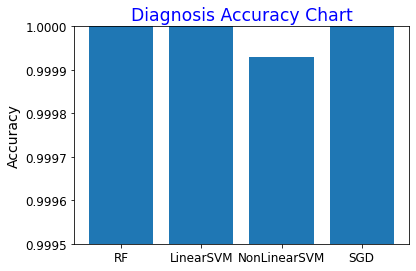

In [0]:
names = ['RF', 'LinearSVM', 'NonLinearSVM',"SGD"]
values = [as_rf_diag, as_svm_diag, as_sgd_diag, as_svm_poly_diag]
plt.bar(names, values)
plt.ylim(0.9995,1)
plt.ylabel("Accuracy")
plt.title("Diagnosis Accuracy Chart", color = "blue", fontsize = "xx-large")
plt.show()

**The Figure 2**, describes the ***Precision*** for Prediction of Diagnoses for diabetes

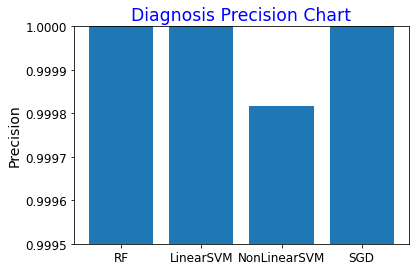

In [0]:
names = ['RF', 'LinearSVM', 'NonLinearSVM',"SGD"]
values = [ps_rf_diag, ps_svm_diag, ps_sgd_diag, ps_svm_poly_diag]
plt.bar(names, values)
plt.ylim(0.9995,1)
plt.ylabel("Precision")
plt.title("Diagnosis Precision Chart", color = "blue", fontsize = "xx-large")
plt.show()

**The Figure 3**, describes the ***Recall*** for Prediction of Diagnoses for diabetes

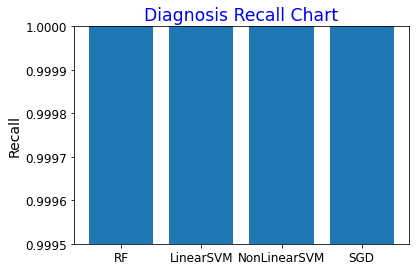

In [0]:
names = ['RF', 'LinearSVM', 'NonLinearSVM',"SGD"]
values = [rs_rf_diag, rs_svm_diag, rs_sgd_diag, rs_svm_poly_diag]
plt.bar(names, values)
plt.ylabel("Recall")
plt.ylim(0.9995,1)
plt.title("Diagnosis Recall Chart", color = "blue", fontsize = "xx-large")
plt.show()

**The Figure 4**, describes the **Cross Validation Score** for Prediction of Diagnoses for diabetes

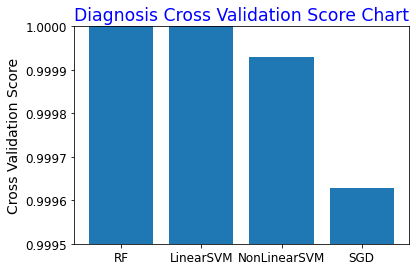

In [0]:
names = ['RF', 'LinearSVM', 'NonLinearSVM',"SGD"]
values = [RFCscore_d.mean(), SVMCscore_d.mean(), PolyCscore_d.mean(), SGDCscore_d.mean()]
plt.bar(names, values)
plt.ylabel("Cross Validation Score")
plt.ylim(0.9995,1)
plt.title("Diagnosis Cross Validation Score Chart", color = "blue", fontsize = "xx-large")
plt.show()

**Below four figures describes the Accuracy, Precision, Recall and Cross Validation Score for Prediction of re-admitted.**

**Figure 5** describes the **Accuracy** percentage **Prediction of re-admitted**. 

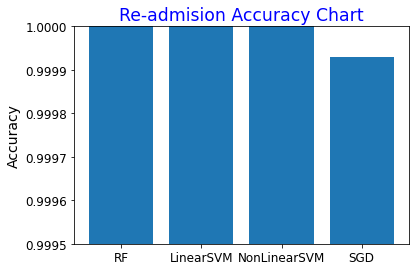

In [0]:
names = ['RF', 'LinearSVM', 'NonLinearSVM',"SGD"]
values = [as_rf_read, as_svm_read, as_sgd_read, as_svm_poly_read]
plt.bar(names, values)
#plt.bar("Methods", "Stat", data = accuracy_score, color = "blue")
#plt.xlabel("RF", "SVM" ,"SGD")
plt.ylim(0.9995,1)
plt.ylabel("Accuracy")
plt.title("Re-admision Accuracy Chart", color = "blue", fontsize = "xx-large")
plt.show()

**The Figure 6**, describes the ***Precision*** percentage prediction of re-admitted. 

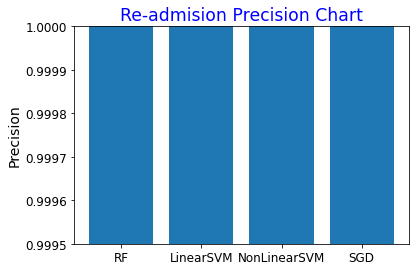

In [0]:
names = ['RF', 'LinearSVM', 'NonLinearSVM',"SGD"]
values = [ps_rf_read, ps_svm_read, ps_sgd_read, ps_svm_poly_read]
plt.bar(names, values)
plt.ylabel("Precision")
plt.ylim(0.9995,1)
plt.title("Re-admision Precision Chart", color = "blue", fontsize = "xx-large")
plt.show()

**The Figure 7**, shows the **Recall** percentage prediction of re-admitted. 

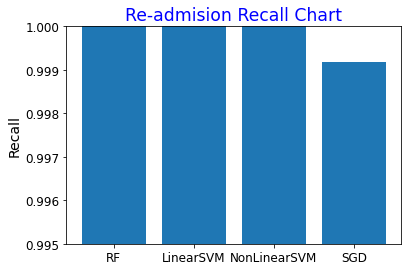

In [0]:
names = ['RF', 'LinearSVM', 'NonLinearSVM',"SGD"]
values = [rs_rf_read, rs_svm_read, rs_sgd_read, rs_svm_poly_read]
plt.bar(names, values)
plt.ylabel("Recall")
plt.ylim(0.995,1)
plt.title("Re-admision Recall Chart", color = "blue", fontsize = "xx-large")
plt.show()

**The Figure 8**, describes the **Cross Validation Score**  of the various classifiers prediction of re-admitted. .

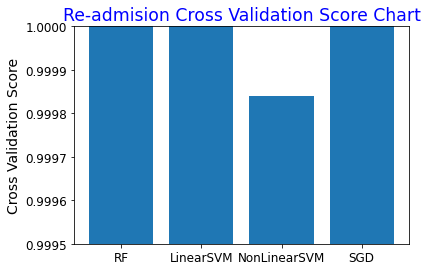

In [0]:
names = ['RF', 'LinearSVM', 'NonLinearSVM',"SGD"]
values = [RFCscore_r.mean(), SVMCscore_r.mean(), PolyCscore_r.mean(), SGDCscore_r.mean()]
plt.bar(names, values)
plt.ylabel("Cross Validation Score")
plt.title("Re-admision Cross Validation Score Chart", color = "blue", fontsize = "xx-large")
plt.ylim(0.9995,1)
plt.show()

# **Models Comparision**

In [0]:
models_com = pd.DataFrame({'Model':['Random Forrest','LinearSVM','SGD','NonLinerSVM'],
                           'Diagnoses Accuracy':[as_rf_diag,as_svm_diag,as_sgd_diag,as_svm_poly_diag],
                           'Readmitted Accuracy':[as_rf_read,as_svm_read,as_sgd_read,as_svm_poly_read],
                           'Diagnoses Precision':[ps_rf_diag,ps_svm_diag,ps_sgd_diag,ps_svm_poly_diag],
                           'Readmitted Precision':[ps_rf_read,ps_svm_read,ps_sgd_read,ps_svm_poly_read],
                           'Diagnoses Recall':[rs_rf_diag,rs_svm_diag,rs_sgd_diag,rs_svm_poly_diag],
                           'Readmitted recall':[rs_rf_read,rs_svm_read,rs_sgd_read,rs_svm_poly_read],})
models_com

,Model,Diagnoses Accuracy,Readmitted Accuracy,Diagnoses Precision,Readmitted Precision,Diagnoses Recall,Readmitted recall
0,Random Forrest,1.000000,1.000000,1.000000,1.0,1.0,1.00000
1,LinearSVM,1.000000,1.000000,1.000000,1.0,1.0,1.00000
2,SGD,0.999929,1.000000,0.999818,1.0,1.0,1.00000
3,NonLinerSVM,1.000000,0.999929,1.000000,1.0,1.0,0.99919
